In [1]:
import random

import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_x = mnist.train.images
train_y = mnist.train.labels

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

idx = np.argsort(train_y)
train_x = train_x[idx]
train_y = train_y[idx]

print(train_x.shape)
print(train_y.shape)

(55000, 784)
(55000,)


In [4]:
cnt = -1
train_x_per_class = {}
for i in range(train_x.shape[0]):
    if cnt == train_y[i]:
        train_x_per_class[cnt].append(train_x[i])
    else:
        cnt += 1
        train_x_per_class[cnt] = []

for i in range(len(train_x_per_class)):
    print(len(train_x_per_class[i]))

5443
6178
5469
5637
5306
4986
5416
5714
5388
5453


In [5]:
total_epochs = 1000
batch_size = 100
learning_rate = 0.001
random_size = 100
image_size = 28*28
z_dim = 120

In [6]:
init = tf.random_normal_initializer(mean=0, stddev=0.15)

def encoder(x, reuse=False):
    l = [image_size, 50, 30, z_dim]
    with tf.variable_scope(name_or_scope='mnist_encoder', reuse=reuse) as scope:
        out1 = tf.layers.dense(x, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

def decoder(z, reuse=False):
    l = [z_dim, 30, 50, image_size]
    with tf.variable_scope(name_or_scope='mnist_decoder', reuse=reuse) as scope:
        out1 = tf.layers.dense(z, l[1], activation=tf.nn.relu)
        out2 = tf.layers.dense(out1, l[2], activation=tf.nn.relu)
        output = tf.layers.dense(out2, l[3], activation=tf.nn.sigmoid)
        return output

In [7]:
def random_z():
    return np.random.normal(size=[1, z_dim])

def distance(x1, x2, reuse=False):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    final_shape = tf.concat([x1_shape[0:1], x2_shape], 0)
    x1_tiled = tf.reshape(tf.tile(x1, [1, x2_shape[0]]), final_shape)
    x2_tiled = tf.reshape(tf.tile(x2, [x1_shape[0], 1]), final_shape)
    output = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(x1_tiled - x2_tiled), 1)))
    return output

In [8]:
g = tf.Graph()

with g.as_default():
    X1 = tf.placeholder(tf.float32, [None, image_size])
    X2 = tf.placeholder(tf.float32, [None, image_size])
    Z = tf.placeholder(tf.float32, [1, z_dim])

    enc1 = encoder(X1)
    dec1 = decoder(enc1)

    enc2 = encoder(X2, True)
    dec2 = decoder(enc2, True)

    loss1 = tf.reduce_mean(tf.square(X1 - dec1))
    loss2 = tf.reduce_mean(tf.square(X2 - dec2))
    avg_loss = -100 * tf.square(tf.reduce_mean(X1) - tf.reduce_mean(X2))
    var_loss1 = tf.reduce_mean(tf.reduce_mean(tf.square(X1)) - tf.square(tf.reduce_mean(X1)))
    var_loss2 = tf.reduce_mean(tf.reduce_mean(tf.square(X2)) - tf.square(tf.reduce_mean(X2)))
    loss = loss1 + loss2 + avg_loss + var_loss1 + var_loss2

    t_vars = tf.trainable_variables()
    e_vars = [var for var in t_vars if "encoder" in var.name]
    d_vars = [var for var in t_vars if "decoder" in var.name]
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss, var_list=e_vars + d_vars)
    
    dist = distance(enc1, enc2)

=== Epoch  50  ===
loss:  0.20136918


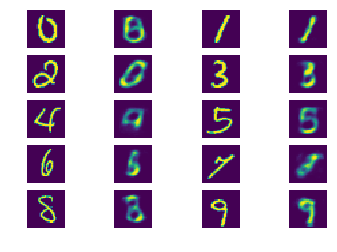

=== Epoch  100  ===
loss:  0.21078184


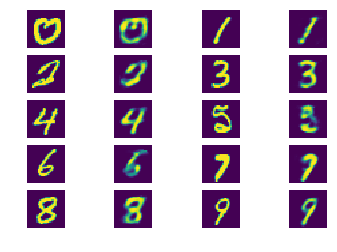

=== Epoch  150  ===
loss:  0.22374523


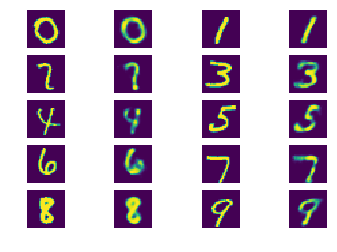

=== Epoch  200  ===
loss:  -0.17869222


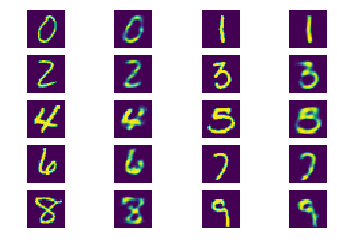

=== Distances ===
0 0 2.1476774
0 1 3.5224824
0 2 2.750052
0 3 2.621491
0 4 2.90097
0 5 2.6493332
0 6 2.7788193
0 7 2.9149644
0 8 2.7212334
0 9 2.8627787

1 1 2.36278
1 2 3.181389
1 3 3.1513743
1 4 3.1603658
1 5 3.2251537
1 6 3.1688623
1 7 3.2743645
1 8 2.893257
1 9 3.1639853

2 2 2.394396
2 3 2.6147125
2 4 2.830048
2 5 2.8335993
2 6 2.6459422
2 7 3.003729
2 8 2.667353
2 9 2.9087305

3 3 2.277932
3 4 2.8265696
3 5 2.6230009
3 6 2.8260112
3 7 2.8445923
3 8 2.5759182
3 9 2.8142078

4 4 2.4460576
4 5 2.7887676
4 6 2.7185404
4 7 2.7716315
4 8 2.6293426
4 9 2.5386853

5 5 2.5419662
5 6 2.7370853
5 7 2.8637285
5 8 2.58772
5 9 2.790187

6 6 2.261207
6 7 3.172308
6 8 2.7565303
6 9 2.9146256

7 7 2.3354628
7 8 2.7722976
7 9 2.6270864

8 8 2.2914574
8 9 2.6726594

9 9 2.410181

=== Epoch  250  ===
loss:  -0.31931892


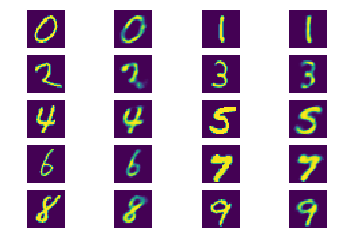

=== Epoch  300  ===
loss:  0.19964796


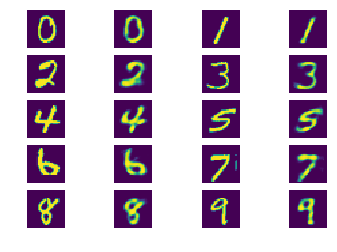

=== Epoch  350  ===
loss:  0.14665645


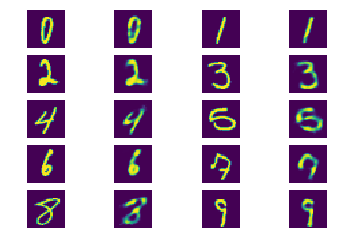

=== Epoch  400  ===
loss:  0.22844952


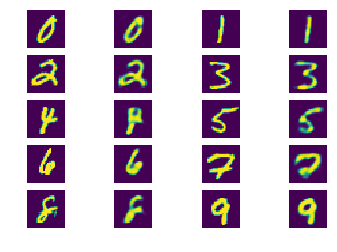

=== Distances ===
0 0 1.8202412
0 1 2.8819323
0 2 2.4113753
0 3 2.3089619
0 4 2.530906
0 5 2.328258
0 6 2.467171
0 7 2.5138829
0 8 2.3491096
0 9 2.4243476

1 1 1.991693
1 2 2.6917796
1 3 2.6499386
1 4 2.7070022
1 5 2.7250602
1 6 2.6550615
1 7 2.7223814
1 8 2.3960733
1 9 2.6460392

2 2 2.1736836
2 3 2.3271565
2 4 2.5180252
2 5 2.5090284
2 6 2.4114177
2 7 2.60618
2 8 2.3438697
2 9 2.501692

3 3 2.0200527
3 4 2.4715269
3 5 2.3212535
3 6 2.5369465
3 7 2.4681559
3 8 2.24756
3 9 2.3818622

4 4 2.125032
4 5 2.4388902
4 6 2.4236982
4 7 2.366208
4 8 2.3217165
4 9 2.1368043

5 5 2.2474437
5 6 2.4727
5 7 2.5049267
5 8 2.26121
5 9 2.3624651

6 6 2.065716
6 7 2.7355776
6 8 2.3953114
6 9 2.5247934

7 7 2.0037224
7 8 2.4173324
7 9 2.1577177

8 8 2.0168009
8 9 2.2761712

9 9 1.9714305

=== Epoch  450  ===
loss:  -0.053356927


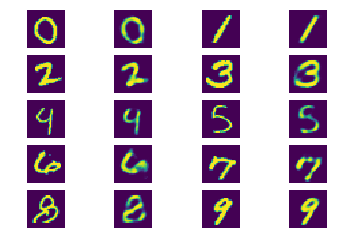

=== Epoch  500  ===
loss:  -0.15043259


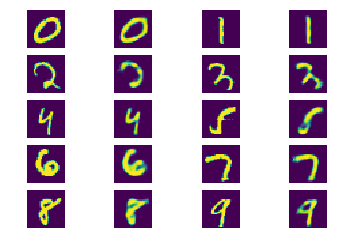

=== Epoch  550  ===
loss:  0.21762627


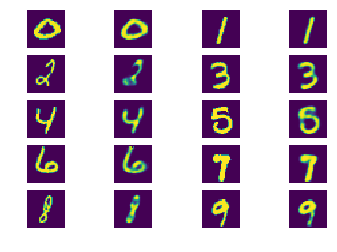

=== Epoch  600  ===
loss:  0.18143699


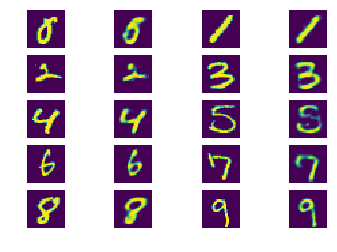

=== Distances ===
0 0 1.8027842
0 1 2.8715394
0 2 2.3551614
0 3 2.2536016
0 4 2.4887908
0 5 2.2866604
0 6 2.4838603
0 7 2.4527795
0 8 2.3792753
0 9 2.4692285

1 1 1.9117525
1 2 2.6279094
1 3 2.5592506
1 4 2.6258235
1 5 2.6135173
1 6 2.6287265
1 7 2.635955
1 8 2.3486736
1 9 2.6438725

2 2 2.1098118
2 3 2.2163072
2 4 2.4394662
2 5 2.3855813
2 6 2.3758857
2 7 2.513453
2 8 2.313347
2 9 2.514116

3 3 1.9362313
3 4 2.3749926
3 5 2.2189727
3 6 2.491284
3 7 2.3637426
3 8 2.2071447
3 9 2.3757193

4 4 2.0819597
4 5 2.3588266
4 6 2.4148962
4 7 2.288006
4 8 2.2945623
4 9 2.1649785

5 5 2.1542623
5 6 2.4450016
5 7 2.3869739
5 8 2.2022562
5 9 2.3511627

6 6 2.1039283
6 7 2.6522768
6 8 2.3877232
6 9 2.540944

7 7 1.9275036
7 8 2.3621192
7 9 2.1461332

8 8 2.0144176
8 9 2.304791

9 9 2.0264037

=== Epoch  650  ===
loss:  0.2152965


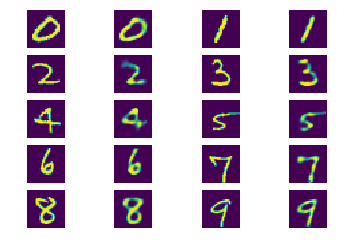

=== Epoch  700  ===
loss:  0.23417851


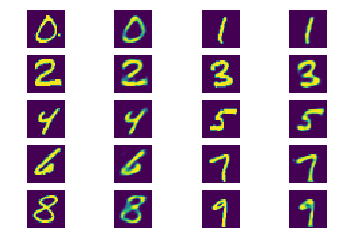

=== Epoch  750  ===
loss:  0.15633552


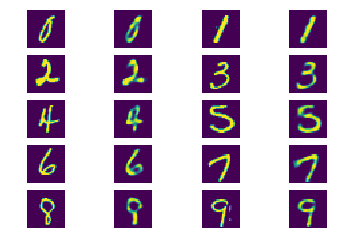

=== Epoch  800  ===
loss:  0.15747365


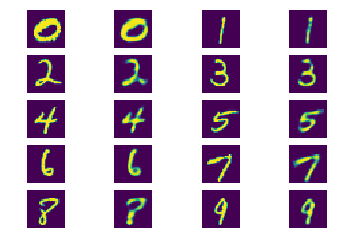

=== Distances ===
0 0 1.7365265
0 1 2.6170707
0 2 2.280071
0 3 2.2025416
0 4 2.3470888
0 5 2.2054987
0 6 2.3975012
0 7 2.335172
0 8 2.203629
0 9 2.3098943

1 1 1.7477903
1 2 2.4364097
1 3 2.372202
1 4 2.4236777
1 5 2.4337242
1 6 2.463493
1 7 2.4577932
1 8 2.1490297
1 9 2.4143925

2 2 2.0501866
2 3 2.169123
2 4 2.3141134
2 5 2.320592
2 6 2.28364
2 7 2.4434617
2 8 2.1659472
2 9 2.3676412

3 3 1.915248
3 4 2.2409506
3 5 2.163482
3 6 2.407048
3 7 2.2649167
3 8 2.0811253
3 9 2.2207408

4 4 1.9478781
4 5 2.2589407
4 6 2.3080745
4 7 2.1801918
4 8 2.1310954
4 9 2.001744

5 5 2.0946887
5 6 2.3559473
5 7 2.2663713
5 8 2.0775476
5 9 2.189142

6 6 1.9993322
6 7 2.5581868
6 8 2.262529
6 9 2.3923

7 7 1.8457735
7 8 2.2019434
7 9 2.0086281

8 8 1.858565
8 9 2.1149557

9 9 1.8548514

=== Epoch  850  ===
loss:  0.19090074


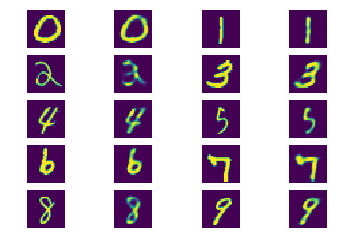

=== Epoch  900  ===
loss:  0.21327701


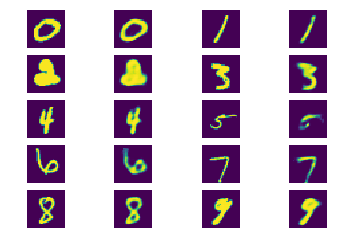

=== Epoch  950  ===
loss:  0.2210091


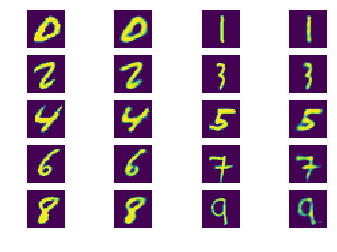

=== Epoch  1000  ===
loss:  -0.21630442


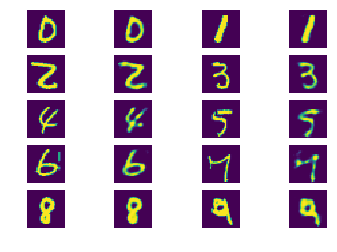

=== Distances ===
0 0 1.6538229
0 1 2.5990443
0 2 2.2234414
0 3 2.0578625
0 4 2.2243876
0 5 2.1019561
0 6 2.2461946
0 7 2.2195868
0 8 2.1016862
0 9 2.1758015

1 1 1.7691722
1 2 2.3952692
1 3 2.3238103
1 4 2.367262
1 5 2.4152656
1 6 2.3609219
1 7 2.4143126
1 8 2.1082835
1 9 2.3586452

2 2 1.99061
2 3 2.0598087
2 4 2.195486
2 5 2.241563
2 6 2.1432226
2 7 2.3208086
2 8 2.0638497
2 9 2.2393556

3 3 1.7868208
3 4 2.1010513
3 5 2.0522828
3 6 2.244723
3 7 2.1290097
3 8 1.9571387
3 9 2.0707493

4 4 1.8354661
4 5 2.150161
4 6 2.1478708
4 7 2.072762
4 8 2.0151618
4 9 1.8908516

5 5 2.0130417
5 6 2.2069912
5 7 2.1638432
5 8 1.9818307
5 9 2.0674033

6 6 1.8477246
6 7 2.412502
6 8 2.1243083
6 9 2.2487721

7 7 1.7492083
7 8 2.0901725
7 9 1.8981377

8 8 1.7579957
8 9 1.9950994

9 9 1.745625



In [9]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(1, total_epochs + 1):
        class1 = random.randint(0, 9)
        class2 = random.randint(0, 9)
        while class1 == class2:
            class1 = random.randint(0, 9)
            class2 = random.randint(0, 9)

        data1 = np.copy(train_x_per_class[class1])
        data2 = np.copy(train_x_per_class[class2])
        np.random.shuffle(data1)
        np.random.shuffle(data2)

        total_batchs = int(min(len(data1), len(data2)) / batch_size)
        for batch in range(total_batchs):
            batch_x1 = data1[(batch * batch_size):((batch + 1) * batch_size)]
            batch_x2 = data2[(batch * batch_size):((batch + 1) * batch_size)]

            sess.run(train, feed_dict={X1: batch_x1, X2: batch_x2})

        if epoch % 50 == 0:
            print("=== Epoch ", epoch, " ===")
            loss_r = sess.run(loss, feed_dict={X1: batch_x1, X2: batch_x2})
            print("loss: ", loss_r)
            
            x_list = []
            for cls in range(10):
                candidate = train_x_per_class[cls]
                x_list.append(candidate[random.randint(0, len(candidate) - 1)])
            x_list = np.asarray(x_list)
            
            gen_list = sess.run(dec1, feed_dict={X1: x_list})
            origimg = x_list.reshape([-1, 28, 28])
            genimg = gen_list.reshape([-1, 28, 28])
            
            _, axes = plt.subplots(5, 4)
            for cls in range(10):
                axes[cls // 2, (cls % 2) * 2 + 0].imshow(origimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 0].axis('off')
                axes[cls // 2, (cls % 2) * 2 + 1].imshow(genimg[cls])
                axes[cls // 2, (cls % 2) * 2 + 1].axis('off')
            plt.show()

        if epoch % 200 == 0:
            print('=== Distances ===')
            for i in range(10):
                for j in range(i, 10):
                    d = sess.run(
                        dist,
                        feed_dict={X1: train_x_per_class[i][0:100], X2: train_x_per_class[j][0:100]}
                    )
                    print(i, j, d)
                print()